importamos librerías

In [1]:
import pandas as pd

import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
import matplotlib.pyplot as plt

cargamos la base de datos

In [2]:
DIR = "/content/drive/MyDrive/Clases/FCEN DM/datos/properati"
df_train = pd.read_csv(f"{DIR}/entrenamiento.zip", index_col="id")
df_test = pd.read_csv(f"{DIR}/a_predecir.zip", index_col="id")

En Test solo tenemos departamentos, casas y cocheras

[]

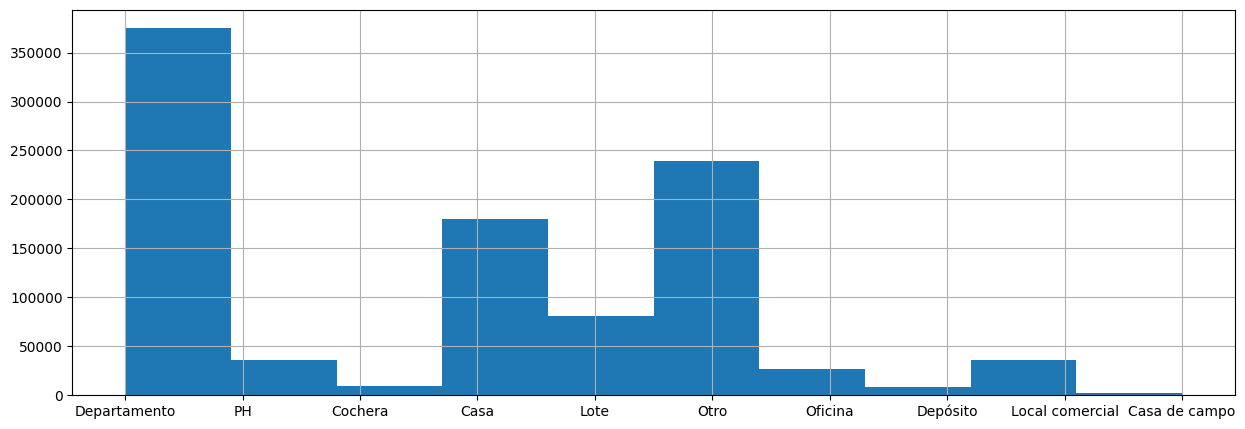

In [3]:
hist1 = df_train["property_type"].hist(figsize=(15,5))
hist1.plot()
#plt.show()

[]

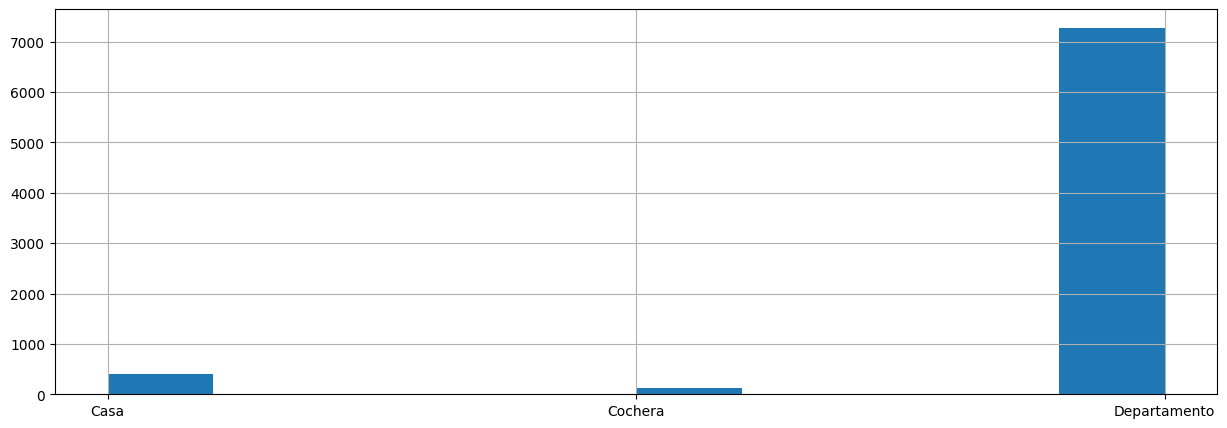

In [4]:
hist1test = df_test["property_type"].hist(figsize=(15,5))
hist1test.plot()
#plt.show()

Eliminamos las entradas que son duplicados exactos, y realizamos algunas correcciones de outliers detectados en la exploración de los datos

In [5]:
df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

df_train.drop_duplicates(inplace = True)

df_test.loc[973771, ['surface_covered']] = 63
df_test.loc[899423, ['surface_covered']] = 71.2
df_test.loc[866125, ['surface_covered']] = 13
df_test.loc[274482, ['property_type']] = "Casa"

De la base de entrenamiento nos quedamos solo con las propiedades en venta, en dólares, en Capital Federal que sean casas, departamentos o cocheras

In [6]:
df_train = df_train[(df_train["ad_type"] == "Propiedad") & (df_train["currency"] == "USD") & (df_train["l2"] == "Capital Federal") & (df_train["operation_type"] == 'Venta') & ((df_train["property_type"] == "Casa") | (df_train["property_type"] == "Departamento")| (df_train["property_type"] == "Cochera"))]

Descartamos los barrios de Capital Federal de Train que no aparecen en Test.

In [7]:
df_train = df_train[~df_train['l3'].isin(['Catalinas', 'Distrito Audiovisual', 'Villa Soldati'])]
df_train = df_train.dropna(subset = ["l3"])

Imputamos los valores faltantes de latitud y longitud con la mediana de cada barrio correspondiente

In [8]:
map_lat_barrio = df_train.groupby('l3').lat.median().to_dict()
df_train['lat_barrio'] = df_train['l3'].map(map_lat_barrio)

map_lon_barrio = df_train.groupby('l3').lon.median().to_dict()
df_train['lon_barrio'] = df_train['l3'].map(map_lon_barrio)

df_train['lat'] = df_train['lat'].fillna(df_train['lat_barrio'])

df_train['lon'] = df_train['lon'].fillna(df_train['lon_barrio'])

map_lat_barrio = df_test.groupby('l3').lat.median().to_dict()
df_test['lat_barrio'] = df_test['l3'].map(map_lat_barrio)

map_lon_barrio = df_test.groupby('l3').lon.median().to_dict()
df_test['lon_barrio'] = df_test['l3'].map(map_lon_barrio)

df_test['lat'] = df_test['lat'].fillna(df_test['lat_barrio'])

df_test['lon'] = df_test['lon'].fillna(df_test['lon_barrio'])

La latitud y la longitud están invertidas, están mal los nombres de las columnas. Lo corregimos.

In [9]:
df_test = df_test.rename(columns={'lat': 'lon', 'lon': 'lat'})
df_train = df_train.rename(columns={'lat': 'lon', 'lon': 'lat'})

Este diccionario contiene los precios promedio de cada barrio, obtenidos de internet. Estos son algunas de las fuentes que utilizamos:

https://tn.com.ar/general/2022/01/14/barrio-por-barrio-los-precios-del-metro-cuadrado-en-la-ciudad-de-buenos-aires/

https://mudafy.com.ar/d/valor-metro-cuadrado-en-caba-por-barrio#sec-mapa-m2

In [10]:
barrios_dict = {"Abasto":1576, "Agronomía":1712, "Almagro":1734, "Balvanera":1576, "Barracas":1523, "Barrio Norte":2447, "Belgrano":2224, "Boca":1232, "Boedo":1614, "Caballito":1903, "Catalinas":1500, "Centro / Microcentro":1533, "Chacarita":1756, "Coghlan":1880, "Colegiales":2017, "Congreso":1655, "Constitución":1321, "Distrito Audiovisual":3500, "Flores":1609, "Floresta":1572, "Las Cañitas":2669, "Liniers":1545, "Mataderos":1467, "Monserrat":1524, "Monte Castro":1658, "Núñez":2138, "Once":1576, "Palermo":2173, "Parque Avellaneda":1372, "Parque Centenario":1683, "Parque Chacabuco":1637, "Parque Chas":1724, "Parque Patricios":1430, "Paternal":1533, "Pompeya":1184, "Puerto Madero":4183, "Recoleta":2106, "Retiro":2000, "Saavedra":1986, "San Cristóbal":1547, "San Nicolás":1548, "San Telmo":1645, "Tribunales":1567, "Vélez Sarsfield":1480, "Versalles":1562, "Villa Crespo":1825, "Villa del Parque":1783, "Villa Devoto":1812, "Villa General Mitre":1550, "Villa Lugano":1124, "Villa Luro":1623, "Villa Ortuzar":1737, "Villa Pueyrredón":1803, "Villa Real":1675, "Villa Riachuelo":785, "Villa Santa Rita":1581, "Villa Soldati":930, "Villa Urquiza":2038}


Usamos la columna con los barrios en train y en test, para crear una nueva columna de precio/m² usando el diccionario anterior

In [11]:
df_train["precio_m2"] = df_train["l3"].map(barrios_dict)
df_test["precio_m2"] = df_test["l3"].map(barrios_dict)

El siguiente es un valor que nos pareció razonable para completar los NAs. Es un valor que se acerca al precio promedio del AMBA (Provincia), que puede ser útil para los NAs que mayormente provendrán de las propiedades que están catalogadas como Capital Federal, y sin embargo están en el límite pero del lado de provincia (y con un precio promedio más bajo).

In [12]:
df_test["precio_m2"] = df_test["precio_m2"].fillna(1630)

Hay algunos outliers en Test en cuanto a la posición geográfica

<Axes: xlabel='lon', ylabel='lat'>

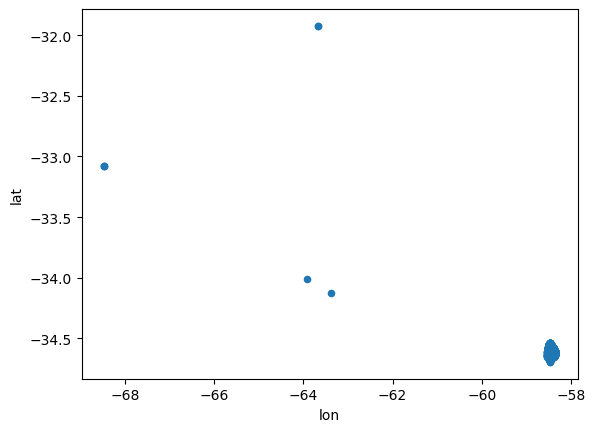

In [13]:
df_test.plot.scatter("lon", "lat")

Pero el resto de los puntos se ubican en una región que se asemeja a la Ciudad de Buenos Aires, con algunos puntos que se alejan.

<Axes: xlabel='lon', ylabel='lat'>

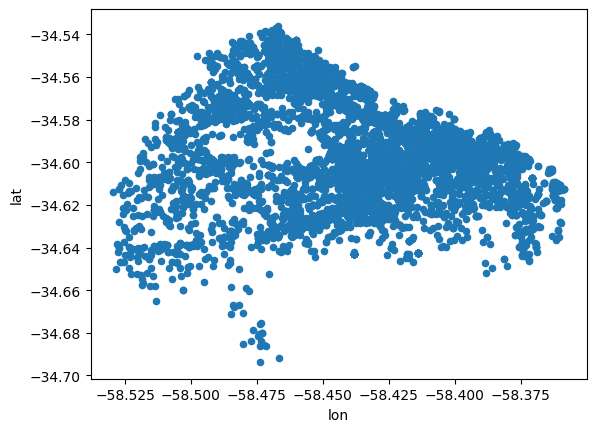

In [14]:
filtro_posicion = (df_test.lon>(-60))
df_test.loc[filtro_posicion].plot.scatter("lon", "lat")

Imputamos los datos faltantes de latitud y longitud con la mediana

In [15]:
df_train.lat = df_train.lat.fillna(df_train.lat.median())
df_train.lon = df_train.lon.fillna(df_train.lon.median())
df_test.lat = df_test.lat.fillna(df_test.lat.median())
df_test.lon = df_test.lon.fillna(df_test.lon.median())

Creamos las dummies para el tipo de propiedad

In [16]:
es_casa = {'Casa': True, 'Departamento': False, 'Cochera': False}
es_cochera = {'Casa': False, 'Departamento': False, 'Cochera': True}
es_depto = {'Casa': False, 'Departamento': True, 'Cochera': False}

df_train["es_casa"] = df_train["property_type"].map(es_casa)
df_train["es_cochera"] = df_train["property_type"].map(es_cochera)
df_train["es_depto"] = df_train["property_type"].map(es_depto)

df_test["es_casa"] = df_test["property_type"].map(es_casa)
df_test["es_cochera"] = df_test["property_type"].map(es_cochera)
df_test["es_depto"] = df_test["property_type"].map(es_depto)

Donde falta la superficie cubierta la tomamos de la total, y viceversa, en train y en test.

In [17]:
df_train['surface_covered'] = df_train['surface_covered'].fillna(df_train['surface_total'])
df_train['surface_total'] = df_train['surface_total'].fillna(df_train['surface_covered'])

df_test['surface_covered'] = df_test['surface_covered'].fillna(df_test['surface_total'])
df_test['surface_total'] = df_test['surface_total'].fillna(df_test['surface_covered'])

La superficie cubierta no puede superar a la total. Donde eso ocurra, intercambiamos los valores

In [18]:
superficie_cubierta_supera_total = df_train.surface_covered>df_train.surface_total
df_train.loc[superficie_cubierta_supera_total, 'surface_covered'], df_train.loc[superficie_cubierta_supera_total, 'surface_total'] = df_train.loc[superficie_cubierta_supera_total, 'surface_total'], df_train.loc[superficie_cubierta_supera_total, 'surface_covered']

En train, nos quedamos con las propiedades que tengan una superficie total entre 5 y 1400 m².

[]

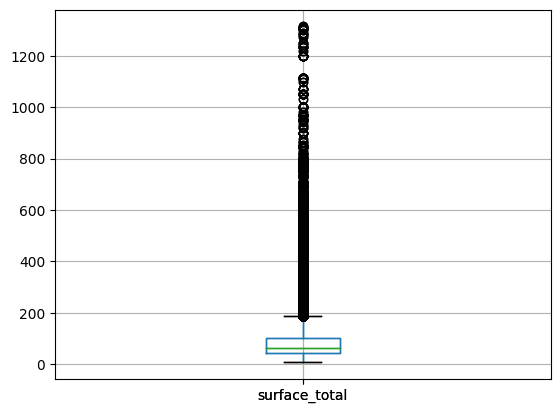

In [21]:
filtro_superficie_nula = (df_train.surface_covered == 0) | (df_train.surface_total == 0)
df_train = df_train[~(filtro_superficie_nula)]

filtro_superficie = (5<df_train.surface_total) & (df_train.surface_total<1400)
boxplot1train = df_train.loc[filtro_superficie].boxplot(column='surface_total')

df_train = df_train[filtro_superficie]
boxplot1train = df_train.boxplot(column='surface_total')
boxplot1train.plot()
#plt.show()

[]

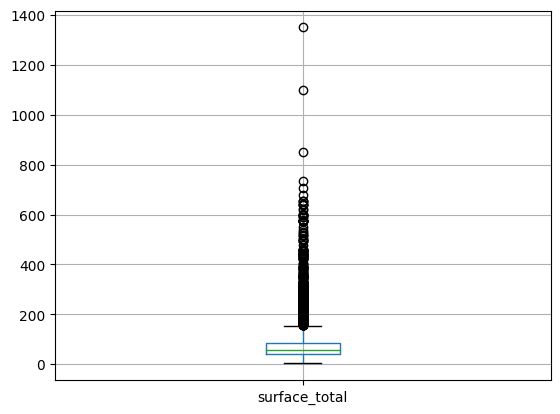

In [22]:
boxplot1test = df_test.boxplot(column='surface_total')
boxplot1test.plot()
#plt.show()

Vemos cómo queda la superficie cubierta vs. la total en train.

<Axes: xlabel='surface_total', ylabel='surface_covered'>

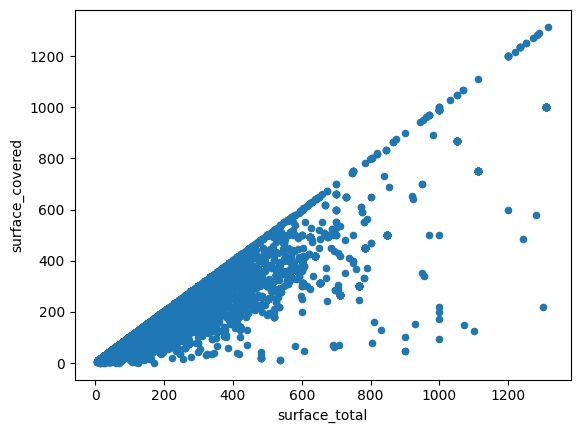

In [23]:
df_train.plot.scatter("surface_total", "surface_covered")

Descartamos los registros en train donde falta el precio

In [ ]:
df_train = df_train.dropna(subset = ["price"])

Nos quedamos con las propiedades que cuesten entre USD 1 y 30.000.000

In [ ]:
filtro_precio = (1<df_train.price) & (df_train.price<3e7)
df_train = df_train[filtro_precio]

Calculamos el precio por m² a partir de los datos de train (del precio y la superficie cubierta, y de la superficie total), y los aplicamos a test.

In [ ]:
df_train['precio_m2_calc_cubierta'] = df_train['price'] / df_train['surface_covered']
df_train['precio_m2_calc_total'] = df_train['price'] / df_train['surface_total']
map_precio_m2_barrio_cubierta = df_train.groupby('l3').precio_m2_calc_cubierta.median().to_dict()
df_train['precio_m2_barrio_cubierta'] = df_train['l3'].map(map_precio_m2_barrio_cubierta)

map_precio_m2_barrio_total = df_train.groupby('l3').precio_m2_calc_total.median().to_dict()
df_train['precio_m2_barrio_total'] = df_train['l3'].map(map_precio_m2_barrio_total)

df_test['precio_m2_barrio_total'] = df_test['l3'].map(map_precio_m2_barrio_total)
df_test['precio_m2_barrio_cubierta'] = df_test['l3'].map(map_precio_m2_barrio_cubierta)

Eliminamos de train aquellos registros que tengan un precio por m² calculado a partir de la superficie cubierta mayor que 15000 USD/m²

In [ ]:
filtro_precio_m2 = df_train.precio_m2_calc_cubierta > 15000
df_train = df_train[~(filtro_precio_m2)]

Elegimos las columnas sobre las cuales queremos que entrene el modelo.
Son latitud, longitud, superficie total, superficie cubierta, dummies de tipo de propiedad, precio / m² (de bibliografía). Precio / m² calculado a partir de la superficie cubierta y la total.

In [ ]:
col_list = ["lat", "lon", "surface_total", "surface_covered", "es_casa", "es_cochera", "es_depto", "precio_m2", "precio_m2_barrio_cubierta", "precio_m2_barrio_total", "price"]

df_train = df_train.loc[:,col_list]
df_test = df_test.loc[:,col_list]

df_train = df_train.select_dtypes(include=['float64', 'int64', 'int32', 'int16', 'int8', 'bool'])

X = df_train[df_train.columns.drop('price')]
y = df_train['price']

In [ ]:
df_train["precio_m2"] = df_train["precio_m2"].fillna(df_train["precio_m2"].median())

La siguiente sección de código fue provista por los docentes, y su propósito es ajustar los hiperparámetros del Random Forest

In [ ]:
#resultados = []

#for n_estimators in [50, 100, 500, 1000]:
#    for max_depth in [5, 10, 15, 30]:
#        print(f"{n_estimators=} -- {max_depth=}")

#        # Creamos el modelo
#        reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42)

#        scores_train = []
#        scores_test = []

#        # Validación cruzada, 10 folds, shuffle antes, semilla aleatoria
#        kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

#        for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
#            # Partimos el fold en entrenamiento y prueba...
#            X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

#            # Entrenamos el modelo en entramiento
#            reg.fit(X_train, y_train)

#            # Predecimos en train
#            y_pred = reg.predict(X_train)

#            # Medimos la performance de la predicción en entramiento
#            score_train = sk.metrics.root_mean_squared_error(y_train, y_pred)
#            scores_train.append(score_train)

#            # Predecimos en test
#            y_pred = reg.predict(X_test)

#            # Medimos la performance de la predicción en prueba
#            score_test = sk.metrics.root_mean_squared_error(y_test, y_pred)
#            scores_test.append(score_test)

#            print("\t", f"{fold=}, {score_train=} {score_test=}")
#            media_scores_entrenamiento = pd.Series(scores_train).mean()
#            std_scores_entrenamiento = pd.Series(scores_train).std()
#            media_scores_prueba = pd.Series(scores_test).mean()
#            std_scores_prueba=pd.Series(scores_test).std()

#        print(f"Media de scores en entrenamiento={media_scores_entrenamiento}, std={std_scores_entrenamiento}")
#        print(f"Media de scores en prueba={media_scores_prueba}, std={std_scores_prueba}")
#        print()
#        resultados.append([n_estimators, max_depth, media_scores_entrenamiento, std_scores_entrenamiento, media_scores_prueba, std_scores_prueba])


Tuvimos que incluir las siguientes líneas de código en el Colab porque si no el bloque que le sigue no corría por los NAs en train y test.
El score da ligeramente peor que en la versión local que no incluye estas líneas.

In [ ]:
#Elegimos el mismo valor que en test para imputar el precio por m2 de bibliografía
df_train["precio_m2"] = df_train["precio_m2"].fillna(1630)
df_test['precio_m2_barrio_total'] = df_test['precio_m2_barrio_total'].fillna(df_test['precio_m2_barrio_total'].median())
df_test['precio_m2_barrio_cubierta'] = df_test['precio_m2_barrio_cubierta'].fillna(df_test['precio_m2_barrio_cubierta'].median())

Bloque final de código en el que se realiza la predicción, se guarda en un archivo y se ve la contribución de las columnas al modelo

In [ ]:
## Datos a predecir
X = df_train[df_train.columns.drop('price')]
y = df_train['price']



X_test = df_test[df_train.columns.drop('price')]

# Entrenamos el modelo usando todos los datos de entrenamiento
# TODO: Poner los valores de hiperparámetros que mejor dieron en el paso anterior
n_estimators = 1000
max_depth = 30
reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42)
reg.fit(X, y)

# Predecimos
df_test['price'] = reg.predict(X_test)

# Creamos el dataframe para entregar
df_sol = df_test[["price"]]

# Tests de validación de la predicción antes de subirla
# Estos tests TIENEN que pasar sin error

assert (df_sol["price"] <= 0).sum() == 0, "Hay predicciones de precios menores o iguales a 0."
assert df_sol.shape[0] == 7808, f"La cantidad de filas no es correcta. Es {df_sol.shape[0]} y debe ser 7808."
assert df_sol.shape[1] == 1, f"La cantidad de columnas no es correcta. Es {df_sol.shape[1]} y debe ser 1."
assert 'price' in df_sol.columns, "Falta la columna 'price'."
assert df_sol.index.name == 'id', "El índice debe llamarse 'id'."

version = "v002e-modif2-entrega-final"
df_test['price'].to_csv(f"{DIR}/solucion-{version}.csv", index=True)


imp = pd.DataFrame({
    "feature": reg.feature_names_in_,
    "importance": reg.feature_importances_
})
imp.sort_values(by="importance", ascending=False)


,feature,importance
3,surface_covered,0.632624
9,precio_m2_barrio_total,0.092071
1,lon,0.076879
2,surface_total,0.061835
8,precio_m2_barrio_cubierta,0.059612
0,lat,0.055193
6,es_depto,0.010184
4,es_casa,0.004981
5,es_cochera,0.003313
7,precio_m2,0.003307
